# Deep Learning - Assigment 1

### Group Number: 22

### Teammates:
1. **Mahshid Jafar Tajrishi**
2. **Bar Melinarskiy**
3. **Cis van Aken**
4. **Simon van Klompenburg**

## Imports entire notebook

In [35]:
# Importing libraries
import pandas as pd
import numpy as np
from scipy.io import loadmat
from IPython.display import display
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchsummary import summary
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
torch.autograd.set_detect_anomaly(True)
from copy import deepcopy as dc
import random
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import json
from scipy.interpolate import interp1d

## Global Definitions

In [36]:
# Path to the zip file
data_dir = "./Data"
data_path = f"{data_dir}/Xtrain.mat"

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set pandas display options to show all columns
pd.set_option('display.max_columns', None)

# Set a professional style for the plots
sns.set_theme(style="whitegrid")

model_name = "LSTM"
model_pth_path = f"best_model_{model_name}.pth"

In [37]:
# Check if CUDA is available
print(torch.__version__)
print(torch.version.cuda)  # Should match CUDA 12.5
print(torch.backends.cudnn.version())  # Should return a version, not None
print(torch.cuda.is_available())  # Should return True

2.5.1
None
90100
True


### Utilities 

In [38]:
def create_sequences(data, window_size, forecast_steps=1):
    X, y = [], []
    for i in range(len(data) - window_size - forecast_steps + 1):
        X.append(data[i:i + window_size, 0])
        y.append(data[i + window_size:i + window_size + forecast_steps, 0])
    X = np.array(X).reshape(-1, window_size, 1)
    y = np.array(y).reshape(-1, forecast_steps)
    return X, y

def prepare_dataloader(series, window_size, batch_size=16):
    """
    Preprocess the datasets for the transformer model.

    Args:
        series: Array of numbers with the sequence of the laser measurements.
        window_size: Integer, the sliding window size.
        batch_size: The number of samples used in one forward and backward pass through the network.

    Returns:
        DataLoader, X, y
    """
    X, y = create_sequences(series, window_size)
    # Ensure proper shapes: X → (N, seq_len, input_dim), y → (N, input_dim)
    X_tensor = torch.tensor(X, dtype=torch.float32)  # Shape: (N, seq_len, input_dim)
    y_tensor = torch.tensor(y, dtype=torch.float32)  # Shape: (N, input_dim)
    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False), X_tensor, y_tensor

def train_model(model, train_loader, val_loader, attempt_index, epochs=20, lr=1e-3, teacher_forcing_prob=0.5, patience=10):
    """
    Train the given model with validation and return the final validation L1 loss.
    Includes early stopping based on validation loss.
    Logs all metrics (L1, MSE, MAE) for each epoch into a DataFrame.
    """
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
    # Define loss functions
    huberLoss_criterion = nn.HuberLoss()  # Huber Loss
    mse_criterion = nn.MSELoss()  # MSE Loss
    mae_criterion = nn.L1Loss()  # MAE Loss (same as L1 Loss)

    best_val_loss = float('inf')
    best_model_state = model.state_dict()  # Initialize with the current model state
    no_improvement_epochs = 0  # Counter for early stopping

    # DataFrame to store metrics
    metrics_df = pd.DataFrame(columns=["trial_id", "epoch", "train_l1", "train_mse", "train_mae", "val_l1", "val_mse", "val_mae"])

    # Progress bar for epochs
    epochs_pbar = tqdm(range(epochs), desc=f"Trial: {attempt_index}", unit="epoch")

    for epoch in epochs_pbar:
        # Training phase
        model.train()
        running_train_huberLoss_loss = 0.0
        running_train_mse_loss = 0.0
        running_train_mae_loss = 0.0

        for batch_index, batch in enumerate(train_loader):
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)

            # Forward pass
            output = model(x_batch)

            # Apply teacher forcing
            if random.random() < teacher_forcing_prob:
                x_batch = x_batch.clone()  # Avoid in-place modification
                x_batch[:, -1, 0] = y_batch[:, 0]

            # Calculate loss
            huberLoss_loss = huberLoss_criterion(output, y_batch)
            mse_loss = mse_criterion(output, y_batch)
            mae_loss = mae_criterion(output, y_batch)

            running_train_huberLoss_loss += huberLoss_loss.item()
            running_train_mse_loss += mse_loss.item()
            running_train_mae_loss += mae_loss.item()

            # Backward pass
            optimizer.zero_grad()
            mae_loss.backward()
            optimizer.step()

        avg_train_huberLoss_loss = running_train_huberLoss_loss / len(train_loader)
        avg_train_mse_loss = running_train_mse_loss / len(train_loader)
        avg_train_mae_loss = running_train_mae_loss / len(train_loader)

        # Validation phase
        model.eval()
        running_val_huberLoss_loss = 0.0
        running_val_mse_loss = 0.0
        running_val_mae_loss = 0.0

        with torch.no_grad():
            for batch in val_loader:
                x_batch, y_batch = batch[0].to(device), batch[1].to(device)
                output = model(x_batch)

                huberLoss_loss = huberLoss_criterion(output, y_batch)
                mse_loss = mse_criterion(output, y_batch)
                mae_loss = mae_criterion(output, y_batch)

                running_val_huberLoss_loss += huberLoss_loss.item()
                running_val_mse_loss += mse_loss.item()
                running_val_mae_loss += mae_loss.item()

        avg_val_huberLoss_loss = running_val_huberLoss_loss / len(val_loader)
        avg_val_mse_loss = running_val_mse_loss / len(val_loader)
        avg_val_mae_loss = running_val_mae_loss / len(val_loader)

        # Save metrics to DataFrame
        new_row = pd.DataFrame([{
            "trial_id": attempt_index,
            "epoch": epoch + 1,
            "train_HuberLoss": avg_train_huberLoss_loss,
            "train_MSE": avg_train_mse_loss,
            "train_MAE": avg_train_mae_loss,
            "val_HuberLoss": avg_val_huberLoss_loss,
            "val_MSE": avg_val_mse_loss,
            "val_MAE": avg_val_mae_loss
        }])
        metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

        # Save the best model
        if avg_val_mae_loss < best_val_loss:
            best_val_loss = avg_val_mae_loss
            best_model_state = model.state_dict()
            no_improvement_epochs = 0  # Reset early stopping counter
        else:
            no_improvement_epochs += 1  # Increment early stopping counter

        # Early stopping
        if no_improvement_epochs >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

        # Adjust learning rate
        scheduler.step()

        # Update progress bar
        epochs_pbar.set_postfix(
            Train_huberLoss_Loss=avg_train_huberLoss_loss,
            Train_MSE_Loss=avg_train_mse_loss,
            Train_MAE_Loss=avg_train_mae_loss,
            Val_huberLoss_Loss=avg_val_huberLoss_loss,
            Val_MSE_Loss=avg_val_mse_loss,
            Val_MAE_Loss=avg_val_mae_loss,
        )

    # Load the best model
    model.load_state_dict(best_model_state)

    return best_val_loss, metrics_df  # Return the best validation L1 loss and metrics DataFrame

### Long short-term memory (LSTM) RNN Model

In [39]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers, dropout=0.0) :
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True,
                              dropout=dropout if num_stacked_layers > 1 else 0.0)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

### Load and Split the dataset into train-validation

In [40]:
# Define augmentation functions
def add_noise(x, std=0.002):
    return x + np.random.normal(0, std, size=x.shape)

def add_drift(x, strength=0.05):
    drift = np.linspace(0, strength, num=len(x)).reshape(-1, 1)
    return x + drift

def time_warp(x, stretch_factor=1.15):
    original_steps = np.arange(len(x))
    new_steps = np.linspace(0, len(x) - 1, int(len(x) * stretch_factor))
    warped = interp1d(original_steps, x.ravel(), kind='linear', fill_value="extrapolate")(new_steps)
    warped = warped[:len(x)]  # clip/pad to original size
    return warped.reshape(-1, 1)

# Define jittering function
def add_jitter(x, std=0.01):
    """
    Add small random perturbations (jitter) to the data.

    Args:
        x (np.ndarray): Input data.
        std (float): Standard deviation of the jitter.

    Returns:
        np.ndarray: Jittered data.
    """
    return x + np.random.normal(0, std, size=x.shape)

data = loadmat(data_path)
measurements = data['Xtrain']
# Check the shape of the data
print("Shape of measurements:", measurements.shape)

# Display the first few rows of the data
print(f"First 5 measurements: {measurements[:5]}")

print(f"measurements range: min={measurements.min()}, max={measurements.max()}")

# Creating sequences
max_window_size = 50  # Maximum window size
# Split data into training and validation sets
size_of_test = 200 + max_window_size  # 200 steps for testing + window size
train_data, val_data = measurements[:-size_of_test], measurements[-size_of_test:]

# Normalize the training data
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_normalized = scaler.fit_transform(train_data)

# Normalize the validation data using the same scaler
val_data_normalized = scaler.transform(val_data)

# Augment training data
print(f"Train shape before augmention: {train_data.shape}")

# augmented = [train_data]  # 1x original

# for _ in range(2):  # 2x noise
#     augmented.append(add_noise(train_data))

# for _ in range(2):  # 2x drift
#     augmented.append(add_drift(train_data))

# for _ in range(2):  # 2x time warp
#     augmented.append(time_warp(train_data))

# for _ in range(2):  # 2x jittering
#     augmented.append(add_jitter(train_data))

# train_augmented = np.vstack(augmented)
# print("Augmented shape:", train_augmented.shape)

# Creating sequences
train_dataset, val_dataset = train_data_normalized, val_data_normalized

print(f"Train shape: {train_dataset.shape}, Val shape: {val_dataset.shape}")
print(f"train_dataset range: min={train_dataset.min()}, max={train_dataset.max()}")
print(f"val_dataset range: min={val_dataset.min()}, max={val_dataset.max()}")

Shape of measurements: (1000, 1)
First 5 measurements: [[ 86]
 [141]
 [ 95]
 [ 41]
 [ 22]]
measurements range: min=2, max=255
Train shape before augmention: (750, 1)
Train shape: (750, 1), Val shape: (250, 1)
train_dataset range: min=0.0, max=1.0
val_dataset range: min=0.03952569169960474, max=0.6996047430830039


In [41]:
# Plot the train_dataset with different colors for each augmentation type
def plot_augmented_data(train_data, augmented_data, num_augmentations):
    plt.figure(figsize=(30, 6))
    
    # Plot the original data
    plt.plot(train_data, label="Original Data", color="blue", linewidth=2)
    
    # Plot the augmented data
    start_idx = len(train_data)
    for i in range(num_augmentations):
        end_idx = start_idx + len(train_data)
        if i < 2:
            label = f"Noise Augmentation {i + 1}"
            color = "orange"
        # elif i < 4:
        #     label = f"Drift Augmentation {i - 1}"
        #     color = "green"
        # elif i < 6:
        #     label = f"Time Warp Augmentation {i - 3}"
        #     color = "red"
        else:
            label = f"Jittering Augmentation {i - 5}"
            color = "purple"
        plt.plot(range(start_idx, end_idx), augmented_data[start_idx:end_idx], label=label, color=color, linewidth=1)
        start_idx = end_idx

    plt.xlabel("Time Steps")
    plt.ylabel("Normalized Value")
    plt.title("Augmented Training Data")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Call the function to plot the data
# plot_augmented_data(train_data, train_augmented, num_augmentations=2)

### Training the Model 

In [42]:
best_model = None

# Initialize a global DataFrame to store metrics for all trials
all_metrics_df = pd.DataFrame(columns=["trial_id", "epoch", "train_HuberLoss", "train_MSE", "train_MAE", "val_HuberLoss", "val_MSE", "val_MAE", 
                                       "hidden_size", "num_layers", "learning_rate", "batch_size", "window_size"])

def objective(trial):
    global all_metrics_df  # Use the global DataFrame to store metrics

    # Suggest hyperparameters
    hidden_size = trial.suggest_int('hidden_size', 32, 256, step=32)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    learning_rate = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    window_size = trial.suggest_int('window_size', 5, 25, step=1)
    # dropout = trial.suggest_float('dropout', 0.0, 0.3, step=0.05) 

    # Update data loaders with the suggested batch size
    train_loader, train_X, train_y = prepare_dataloader(train_dataset, window_size, batch_size=batch_size)
    val_loader, val_X, val_y = prepare_dataloader(val_dataset, window_size, batch_size=batch_size)

    # Define the model
    model = LSTM(
        input_size=1,  # Number of features in the input sequence
        hidden_size=hidden_size, # Number of features in the hidden state
        num_stacked_layers=num_layers, # Number of LSTM layers
        # dropout=dropout  # Dropout rate
    ).to(device)

    # Train the model and get the final validation loss and metrics DataFrame
    trial_index = trial.number + 1  # Start from 1 for better readability in logs
    val_loss, metrics_df = train_model(
        model, train_loader, val_loader, attempt_index=trial_index, epochs=100, lr=learning_rate
    )

    # Add trial parameters to the metrics DataFrame
    metrics_df["hidden_size"] = hidden_size
    metrics_df["num_layers"] = num_layers
    metrics_df["learning_rate"] = learning_rate
    metrics_df["batch_size"] = batch_size
    metrics_df["window_size"] = window_size
    # metrics_df["dropout"] = dropout  # Log the dropout value


    # Save the best model
    if trial.number == 0 or val_loss < study.best_value:
        torch.save(model.state_dict(), model_pth_path)
        print(f"Best model saved with trial {trial.number}")
        best_model = model

        # Save the best hyperparameters
        with open(f"best_hyperparameters_{model_name}.json", "w") as f:
            json.dump({
                "hidden_size": hidden_size,
                "num_layers": num_layers,
                "learning_rate": learning_rate,
                "batch_size": batch_size,
                "window_size": window_size,
                # "dropout": dropout  
            }, f)

    # Append the metrics for this trial to the global DataFrame
    all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)

    return val_loss  # Optuna will minimize this


# Create a study object
study = optuna.create_study(direction="minimize")  # Minimize validation loss

# Optimize the objective function
study.optimize(objective, n_trials=100)  # Run 100 trials

# Save the combined metrics DataFrame to a CSV file
csv_path = f"all_trials_metrics_{model_name}.csv"
all_metrics_df.to_csv(csv_path, index=False)
print(f"All metrics saved to {csv_path}")

# Print the best hyperparameters
print("Best hyperparameters:", study.best_params)

# Print the best validation loss
print("Best validation loss:", study.best_value)

# Load the best model
best_model = LSTM(
    input_size=1,
    hidden_size=study.best_params['hidden_size'],
    num_stacked_layers=study.best_params['num_layers']
).to(device)
best_model.load_state_dict(torch.load(model_pth_path))
print("Best model loaded.")

# Update train_loader and val_loader with the best hyperparameters
train_loader, train_X, train_y = prepare_dataloader(train_dataset, study.best_params['window_size'], batch_size=study.best_params['batch_size'])
val_loader, val_X, val_y = prepare_dataloader(val_dataset, study.best_params['window_size'], batch_size=study.best_params['batch_size'])
print("Data loaders updated with best hyperparameters.")

[I 2025-05-07 20:59:50,405] A new study created in memory with name: no-name-d778e72f-9a2e-4730-bb9b-41c12ec451ad


Trial: 1:   0%|          | 0/100 [00:00<?, ?epoch/s]

C:\Users\bar24\AppData\Local\Temp\ipykernel_19876\3414820244.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)
[I 2025-05-07 21:00:20,806] Trial 0 finished with value: 0.015082157915458083 and parameters: {'hidden_size': 32, 'num_layers': 3, 'lr': 0.000308671694086997, 'batch_size': 32, 'window_size': 10}. Best is trial 0 with value: 0.015082157915458083.


Early stopping triggered after 82 epochs.
Best model saved with trial 0


Trial: 2:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:00:43,283] Trial 1 finished with value: 0.04380613844841719 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.00012625747875502592, 'batch_size': 64, 'window_size': 14}. Best is trial 0 with value: 0.015082157915458083.


Trial: 3:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:00:51,772] Trial 2 finished with value: 0.1371588408946991 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 3.158254450952837e-05, 'batch_size': 128, 'window_size': 12}. Best is trial 0 with value: 0.015082157915458083.


Early stopping triggered after 69 epochs.


Trial: 4:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:00:59,949] Trial 3 finished with value: 0.01676365511957556 and parameters: {'hidden_size': 160, 'num_layers': 3, 'lr': 0.005554954378951536, 'batch_size': 32, 'window_size': 8}. Best is trial 0 with value: 0.015082157915458083.


Early stopping triggered after 20 epochs.


Trial: 5:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:01:18,939] Trial 4 finished with value: 0.049532453529536724 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.00018660265697046228, 'batch_size': 64, 'window_size': 16}. Best is trial 0 with value: 0.015082157915458083.


Trial: 6:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:01:33,085] Trial 5 finished with value: 0.007252928393427283 and parameters: {'hidden_size': 96, 'num_layers': 2, 'lr': 0.0020356640018269713, 'batch_size': 32, 'window_size': 17}. Best is trial 5 with value: 0.007252928393427283.


Early stopping triggered after 42 epochs.
Best model saved with trial 5


Trial: 7:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:01:49,007] Trial 6 finished with value: 0.05507604405283928 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 9.708693590541343e-05, 'batch_size': 64, 'window_size': 17}. Best is trial 5 with value: 0.007252928393427283.


Early stopping triggered after 87 epochs.


Trial: 8:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:01:59,630] Trial 7 finished with value: 0.017256687860935926 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.0007940495312405928, 'batch_size': 128, 'window_size': 9}. Best is trial 5 with value: 0.007252928393427283.


Early stopping triggered after 79 epochs.


Trial: 9:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:02:02,268] Trial 8 finished with value: 0.140585258603096 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 8.84566195231371e-05, 'batch_size': 128, 'window_size': 25}. Best is trial 5 with value: 0.007252928393427283.


Early stopping triggered after 16 epochs.


Trial: 10:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:02:12,956] Trial 9 finished with value: 0.021356513258069754 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 0.0004617450276781622, 'batch_size': 64, 'window_size': 7}. Best is trial 5 with value: 0.007252928393427283.


Early stopping triggered after 63 epochs.


Trial: 11:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:02:19,370] Trial 10 finished with value: 0.012847268721088767 and parameters: {'hidden_size': 96, 'num_layers': 1, 'lr': 0.009151939140466742, 'batch_size': 32, 'window_size': 21}. Best is trial 5 with value: 0.007252928393427283.


Early stopping triggered after 22 epochs.


Trial: 12:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:02:26,068] Trial 11 finished with value: 0.014975093421526253 and parameters: {'hidden_size': 96, 'num_layers': 1, 'lr': 0.009017993853658448, 'batch_size': 32, 'window_size': 21}. Best is trial 5 with value: 0.007252928393427283.


Early stopping triggered after 22 epochs.


Trial: 13:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:02:40,262] Trial 12 finished with value: 0.008692759496625513 and parameters: {'hidden_size': 96, 'num_layers': 1, 'lr': 0.002500813952248586, 'batch_size': 32, 'window_size': 20}. Best is trial 5 with value: 0.007252928393427283.


Early stopping triggered after 40 epochs.


Trial: 14:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:02:53,093] Trial 13 finished with value: 0.02651242248248309 and parameters: {'hidden_size': 32, 'num_layers': 1, 'lr': 0.0017417061931245693, 'batch_size': 32, 'window_size': 19}. Best is trial 5 with value: 0.007252928393427283.


Early stopping triggered after 42 epochs.


Trial: 15:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:03:00,453] Trial 14 finished with value: 0.03178374329581857 and parameters: {'hidden_size': 96, 'num_layers': 2, 'lr': 0.001487704317959879, 'batch_size': 32, 'window_size': 23}. Best is trial 5 with value: 0.007252928393427283.


Early stopping triggered after 23 epochs.


Trial: 16:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:03:13,369] Trial 15 finished with value: 0.010738510463852435 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 0.002696062469249378, 'batch_size': 32, 'window_size': 18}. Best is trial 5 with value: 0.007252928393427283.


Early stopping triggered after 39 epochs.


Trial: 17:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:03:21,216] Trial 16 finished with value: 0.027609362499788404 and parameters: {'hidden_size': 64, 'num_layers': 3, 'lr': 0.0033258556586393787, 'batch_size': 32, 'window_size': 14}. Best is trial 5 with value: 0.007252928393427283.


Early stopping triggered after 22 epochs.


Trial: 18:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:03:39,065] Trial 17 finished with value: 0.03343510744161904 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.0008406035472053209, 'batch_size': 32, 'window_size': 5}. Best is trial 5 with value: 0.007252928393427283.


Early stopping triggered after 42 epochs.


Trial: 19:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:03:58,491] Trial 18 finished with value: 0.13921077642589808 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 1.0017911346860323e-05, 'batch_size': 32, 'window_size': 20}. Best is trial 5 with value: 0.007252928393427283.


Early stopping triggered after 55 epochs.


Trial: 20:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:04:08,240] Trial 19 finished with value: 0.012991656549274921 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 0.0009334351011149579, 'batch_size': 128, 'window_size': 24}. Best is trial 5 with value: 0.007252928393427283.


Early stopping triggered after 84 epochs.


Trial: 21:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:04:16,927] Trial 20 finished with value: 0.019186410354450345 and parameters: {'hidden_size': 96, 'num_layers': 2, 'lr': 0.0038711760215803808, 'batch_size': 32, 'window_size': 12}. Best is trial 5 with value: 0.007252928393427283.


Early stopping triggered after 22 epochs.


Trial: 22:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:04:24,169] Trial 21 finished with value: 0.046440486097708344 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 0.0023055791657767962, 'batch_size': 32, 'window_size': 18}. Best is trial 5 with value: 0.007252928393427283.


Early stopping triggered after 22 epochs.


Trial: 23:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:04:31,649] Trial 22 finished with value: 0.025740231852978468 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 0.003353239551809723, 'batch_size': 32, 'window_size': 22}. Best is trial 5 with value: 0.007252928393427283.


Early stopping triggered after 22 epochs.


Trial: 24:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:04:38,757] Trial 23 finished with value: 0.04287066520191729 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 0.0014769718633723694, 'batch_size': 32, 'window_size': 16}. Best is trial 5 with value: 0.007252928393427283.


Early stopping triggered after 22 epochs.


Trial: 25:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:04:45,252] Trial 24 finished with value: 0.020061889197677374 and parameters: {'hidden_size': 64, 'num_layers': 1, 'lr': 0.005696661625048112, 'batch_size': 32, 'window_size': 19}. Best is trial 5 with value: 0.007252928393427283.


Early stopping triggered after 22 epochs.


Trial: 26:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:05:03,654] Trial 25 finished with value: 0.02312748844269663 and parameters: {'hidden_size': 96, 'num_layers': 1, 'lr': 0.0004664719465693398, 'batch_size': 32, 'window_size': 18}. Best is trial 5 with value: 0.007252928393427283.


Early stopping triggered after 62 epochs.


Trial: 27:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:05:10,419] Trial 26 finished with value: 0.021342109772376716 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.0023969658580859214, 'batch_size': 32, 'window_size': 15}. Best is trial 5 with value: 0.007252928393427283.


Early stopping triggered after 22 epochs.


Trial: 28:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:05:21,549] Trial 27 finished with value: 0.00877425167709589 and parameters: {'hidden_size': 64, 'num_layers': 1, 'lr': 0.005236949494210981, 'batch_size': 32, 'window_size': 20}. Best is trial 5 with value: 0.007252928393427283.


Early stopping triggered after 39 epochs.


Trial: 29:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:05:27,106] Trial 28 finished with value: 0.006603629793971777 and parameters: {'hidden_size': 32, 'num_layers': 2, 'lr': 0.0054036579244467085, 'batch_size': 128, 'window_size': 22}. Best is trial 28 with value: 0.006603629793971777.


Early stopping triggered after 60 epochs.
Best model saved with trial 28


Trial: 30:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:05:28,355] Trial 29 finished with value: 0.13859714567661285 and parameters: {'hidden_size': 32, 'num_layers': 3, 'lr': 0.009947342069402423, 'batch_size': 128, 'window_size': 22}. Best is trial 28 with value: 0.006603629793971777.


Early stopping triggered after 12 epochs.


Trial: 31:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:05:30,361] Trial 30 finished with value: 0.14036274701356888 and parameters: {'hidden_size': 32, 'num_layers': 3, 'lr': 0.0011542973294688477, 'batch_size': 128, 'window_size': 25}. Best is trial 28 with value: 0.006603629793971777.


Early stopping triggered after 17 epochs.


Trial: 32:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:05:36,292] Trial 31 finished with value: 0.006413881899788976 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.005013368559625348, 'batch_size': 128, 'window_size': 20}. Best is trial 31 with value: 0.006413881899788976.


Early stopping triggered after 63 epochs.
Best model saved with trial 31


Trial: 33:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:05:41,280] Trial 32 finished with value: 0.00733584351837635 and parameters: {'hidden_size': 32, 'num_layers': 2, 'lr': 0.005366747119646063, 'batch_size': 128, 'window_size': 23}. Best is trial 31 with value: 0.006413881899788976.


Early stopping triggered after 56 epochs.


Trial: 34:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:05:47,315] Trial 33 finished with value: 0.012680163607001305 and parameters: {'hidden_size': 32, 'num_layers': 2, 'lr': 0.004355761760813718, 'batch_size': 128, 'window_size': 23}. Best is trial 31 with value: 0.006413881899788976.


Early stopping triggered after 64 epochs.


Trial: 35:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:05:51,147] Trial 34 finished with value: 0.01427562115713954 and parameters: {'hidden_size': 32, 'num_layers': 2, 'lr': 0.005787869379230714, 'batch_size': 128, 'window_size': 23}. Best is trial 31 with value: 0.006413881899788976.


Early stopping triggered after 43 epochs.


Trial: 36:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:05:58,038] Trial 35 finished with value: 0.006079435348510742 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.006793461697990393, 'batch_size': 128, 'window_size': 13}. Best is trial 35 with value: 0.006079435348510742.


Early stopping triggered after 62 epochs.
Best model saved with trial 35


Trial: 37:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:06:02,197] Trial 36 finished with value: 0.006757367867976427 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.0063194232696109, 'batch_size': 128, 'window_size': 12}. Best is trial 35 with value: 0.006079435348510742.


Early stopping triggered after 44 epochs.


Trial: 38:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:06:06,073] Trial 37 finished with value: 0.012142541818320751 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.006975096530039413, 'batch_size': 128, 'window_size': 12}. Best is trial 35 with value: 0.006079435348510742.


Early stopping triggered after 42 epochs.


Trial: 39:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:06:07,324] Trial 38 finished with value: 0.1357901617884636 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.00026282384021144184, 'batch_size': 128, 'window_size': 10}. Best is trial 35 with value: 0.006079435348510742.


Early stopping triggered after 13 epochs.


Trial: 40:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:06:16,342] Trial 39 finished with value: 0.13962731882929802 and parameters: {'hidden_size': 32, 'num_layers': 2, 'lr': 3.640669402182981e-05, 'batch_size': 128, 'window_size': 13}. Best is trial 35 with value: 0.006079435348510742.


Trial: 41:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:06:22,270] Trial 40 finished with value: 0.004697971744462848 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.008167664290821094, 'batch_size': 128, 'window_size': 10}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 60 epochs.
Best model saved with trial 40


Trial: 42:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:06:25,821] Trial 41 finished with value: 0.007436366751790047 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.007182418159863402, 'batch_size': 128, 'window_size': 10}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 38 epochs.


Trial: 43:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:06:30,499] Trial 42 finished with value: 0.018020580522716045 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.004050354787865371, 'batch_size': 128, 'window_size': 9}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 43 epochs.


Trial: 44:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:06:34,981] Trial 43 finished with value: 0.009686138946563005 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.0072261153240522355, 'batch_size': 128, 'window_size': 11}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 39 epochs.


Trial: 45:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:06:39,252] Trial 44 finished with value: 0.018858606461435556 and parameters: {'hidden_size': 32, 'num_layers': 2, 'lr': 0.009724473309855512, 'batch_size': 64, 'window_size': 13}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 22 epochs.


Trial: 46:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:06:43,147] Trial 45 finished with value: 0.01478817779570818 and parameters: {'hidden_size': 96, 'num_layers': 2, 'lr': 0.0032733233154216747, 'batch_size': 128, 'window_size': 7}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 38 epochs.


Trial: 47:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:06:50,323] Trial 46 finished with value: 0.00905549991875887 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.007131104512219914, 'batch_size': 128, 'window_size': 14}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 42 epochs.


Trial: 48:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:06:54,287] Trial 47 finished with value: 0.011974037624895573 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.004327970931097298, 'batch_size': 128, 'window_size': 11}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 43 epochs.


Trial: 49:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:07:03,892] Trial 48 finished with value: 0.013634814415127039 and parameters: {'hidden_size': 96, 'num_layers': 2, 'lr': 0.0006078073543642743, 'batch_size': 64, 'window_size': 15}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 59 epochs.


Trial: 50:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:07:09,280] Trial 49 finished with value: 0.017797421663999557 and parameters: {'hidden_size': 32, 'num_layers': 3, 'lr': 0.0015503553863199671, 'batch_size': 128, 'window_size': 9}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 57 epochs.


Trial: 51:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:07:14,628] Trial 50 finished with value: 0.008892480283975601 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.0020661300464204233, 'batch_size': 128, 'window_size': 16}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 60 epochs.


Trial: 52:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:07:20,339] Trial 51 finished with value: 0.008164012804627419 and parameters: {'hidden_size': 96, 'num_layers': 2, 'lr': 0.002917025629373729, 'batch_size': 128, 'window_size': 17}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 62 epochs.


Trial: 53:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:07:24,158] Trial 52 finished with value: 0.0077574909664690495 and parameters: {'hidden_size': 96, 'num_layers': 2, 'lr': 0.007660528611788458, 'batch_size': 128, 'window_size': 13}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 42 epochs.


Trial: 54:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:07:31,436] Trial 53 finished with value: 0.007974016014486551 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.004824116512029553, 'batch_size': 64, 'window_size': 21}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 42 epochs.


Trial: 55:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:07:36,520] Trial 54 finished with value: 0.013062610290944576 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.00564963707988184, 'batch_size': 128, 'window_size': 11}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 42 epochs.


Trial: 56:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:07:41,840] Trial 55 finished with value: 0.13488426804542542 and parameters: {'hidden_size': 32, 'num_layers': 2, 'lr': 0.00012753572156482942, 'batch_size': 128, 'window_size': 8}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 50 epochs.


Trial: 57:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:07:46,288] Trial 56 finished with value: 0.01214517280459404 and parameters: {'hidden_size': 96, 'num_layers': 2, 'lr': 0.0036217905650887954, 'batch_size': 128, 'window_size': 14}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 42 epochs.


Trial: 58:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:07:52,821] Trial 57 finished with value: 0.011049052234739065 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.0021085687146876267, 'batch_size': 128, 'window_size': 17}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 63 epochs.


Trial: 59:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:08:04,366] Trial 58 finished with value: 0.02094336412847042 and parameters: {'hidden_size': 32, 'num_layers': 2, 'lr': 0.0011771094726410669, 'batch_size': 64, 'window_size': 12}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 64 epochs.


Trial: 60:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:08:10,885] Trial 59 finished with value: 0.005045003956183791 and parameters: {'hidden_size': 96, 'num_layers': 2, 'lr': 0.008337188014104687, 'batch_size': 128, 'window_size': 19}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 62 epochs.


Trial: 61:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:08:15,342] Trial 60 finished with value: 0.012500877026468515 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.00949791234961482, 'batch_size': 128, 'window_size': 22}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 43 epochs.


Trial: 62:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:08:19,398] Trial 61 finished with value: 0.007958181202411652 and parameters: {'hidden_size': 96, 'num_layers': 2, 'lr': 0.0063477065942262444, 'batch_size': 128, 'window_size': 19}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 39 epochs.


Trial: 63:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:08:23,689] Trial 62 finished with value: 0.008471434470266104 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.007558044248625357, 'batch_size': 128, 'window_size': 20}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 38 epochs.


Trial: 64:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:08:30,123] Trial 63 finished with value: 0.0072925519198179245 and parameters: {'hidden_size': 96, 'num_layers': 2, 'lr': 0.004390857865147272, 'batch_size': 128, 'window_size': 19}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 60 epochs.


Trial: 65:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:08:35,030] Trial 64 finished with value: 0.010513825342059135 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.008366737271631746, 'batch_size': 128, 'window_size': 18}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 45 epochs.


Trial: 66:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:08:42,680] Trial 65 finished with value: 0.01101011922582984 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.002812492802761805, 'batch_size': 128, 'window_size': 21}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 45 epochs.


Trial: 67:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:08:48,007] Trial 66 finished with value: 0.007705734111368656 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.0049654987240434064, 'batch_size': 128, 'window_size': 16}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 40 epochs.


Trial: 68:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:08:52,920] Trial 67 finished with value: 0.0076023912988603115 and parameters: {'hidden_size': 96, 'num_layers': 3, 'lr': 0.003720750974729544, 'batch_size': 128, 'window_size': 15}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 40 epochs.


Trial: 69:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:09:00,546] Trial 68 finished with value: 0.014904000447131693 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.005936683848477944, 'batch_size': 32, 'window_size': 17}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 20 epochs.


Trial: 70:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:09:07,261] Trial 69 finished with value: 0.008929376490414143 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.0018805495832249883, 'batch_size': 128, 'window_size': 24}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 60 epochs.


Trial: 71:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:09:11,522] Trial 70 finished with value: 0.027151836548000574 and parameters: {'hidden_size': 32, 'num_layers': 2, 'lr': 0.009930846663289703, 'batch_size': 64, 'window_size': 19}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 23 epochs.


Trial: 72:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:09:15,926] Trial 71 finished with value: 0.015123643912374973 and parameters: {'hidden_size': 96, 'num_layers': 2, 'lr': 0.0029398181596834556, 'batch_size': 128, 'window_size': 18}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 43 epochs.


Trial: 73:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:09:20,304] Trial 72 finished with value: 0.01059963135048747 and parameters: {'hidden_size': 96, 'num_layers': 2, 'lr': 0.004170885798840154, 'batch_size': 128, 'window_size': 20}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 42 epochs.


Trial: 74:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:09:24,349] Trial 73 finished with value: 0.009133886080235243 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.004992606634537792, 'batch_size': 128, 'window_size': 21}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 40 epochs.


Trial: 75:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:09:29,294] Trial 74 finished with value: 0.010157487355172634 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.006302154016365654, 'batch_size': 128, 'window_size': 19}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 45 epochs.


Trial: 76:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:09:35,101] Trial 75 finished with value: 0.012832347769290209 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.0025075744838933744, 'batch_size': 128, 'window_size': 20}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 58 epochs.


Trial: 77:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:09:42,379] Trial 76 finished with value: 0.010199897224083543 and parameters: {'hidden_size': 96, 'num_layers': 2, 'lr': 0.00834251654867146, 'batch_size': 32, 'window_size': 22}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 22 epochs.


Trial: 78:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:09:47,626] Trial 77 finished with value: 0.1378980576992035 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 6.221587841630686e-05, 'batch_size': 128, 'window_size': 12}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 52 epochs.


Trial: 79:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:09:53,348] Trial 78 finished with value: 0.01283989567309618 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.0036463245709662502, 'batch_size': 128, 'window_size': 13}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 43 epochs.


Trial: 80:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:10:01,143] Trial 79 finished with value: 0.02583428332582116 and parameters: {'hidden_size': 32, 'num_layers': 2, 'lr': 0.004630941796633696, 'batch_size': 32, 'window_size': 11}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 23 epochs.


Trial: 81:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:10:11,193] Trial 80 finished with value: 0.14362674951553345 and parameters: {'hidden_size': 96, 'num_layers': 2, 'lr': 1.667577751622882e-05, 'batch_size': 128, 'window_size': 19}. Best is trial 40 with value: 0.004697971744462848.


Trial: 82:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:10:15,695] Trial 81 finished with value: 0.017204847652465105 and parameters: {'hidden_size': 32, 'num_layers': 2, 'lr': 0.005995291236619063, 'batch_size': 128, 'window_size': 24}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 45 epochs.


Trial: 83:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:10:19,682] Trial 82 finished with value: 0.008456644369289279 and parameters: {'hidden_size': 32, 'num_layers': 2, 'lr': 0.008260839594691946, 'batch_size': 128, 'window_size': 23}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 39 epochs.


Trial: 84:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:10:24,179] Trial 83 finished with value: 0.01035616034641862 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.005084437090850915, 'batch_size': 128, 'window_size': 22}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 44 epochs.


Trial: 85:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:10:28,367] Trial 84 finished with value: 0.011343304067850113 and parameters: {'hidden_size': 32, 'num_layers': 2, 'lr': 0.0066471517496305196, 'batch_size': 128, 'window_size': 21}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 39 epochs.


Trial: 86:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:10:34,237] Trial 85 finished with value: 0.008041030028834939 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.0033310511962538532, 'batch_size': 128, 'window_size': 23}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 58 epochs.


Trial: 87:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:10:44,167] Trial 86 finished with value: 0.1350390650331974 and parameters: {'hidden_size': 32, 'num_layers': 2, 'lr': 0.0002771025452625165, 'batch_size': 128, 'window_size': 10}. Best is trial 40 with value: 0.004697971744462848.


Trial: 88:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:10:48,156] Trial 87 finished with value: 0.0109091573394835 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.0042754711433855425, 'batch_size': 128, 'window_size': 17}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 39 epochs.


Trial: 89:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:10:55,422] Trial 88 finished with value: 0.012535574962384999 and parameters: {'hidden_size': 96, 'num_layers': 2, 'lr': 0.0076250686626565065, 'batch_size': 32, 'window_size': 25}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 22 epochs.


Trial: 90:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:11:03,049] Trial 89 finished with value: 0.013911056099459529 and parameters: {'hidden_size': 32, 'num_layers': 2, 'lr': 0.005315425114300736, 'batch_size': 64, 'window_size': 8}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 42 epochs.


Trial: 91:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:11:12,987] Trial 90 finished with value: 0.050011804327368736 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.00039193973313997554, 'batch_size': 128, 'window_size': 18}. Best is trial 40 with value: 0.004697971744462848.


Trial: 92:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:11:16,839] Trial 91 finished with value: 0.009761408437043428 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.008600269377311936, 'batch_size': 128, 'window_size': 8}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 38 epochs.


Trial: 93:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:11:21,012] Trial 92 finished with value: 0.014225736260414124 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.006805469220116765, 'batch_size': 128, 'window_size': 9}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 39 epochs.


Trial: 94:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:11:25,569] Trial 93 finished with value: 0.010836660396307707 and parameters: {'hidden_size': 96, 'num_layers': 2, 'lr': 0.006727086555162112, 'batch_size': 128, 'window_size': 10}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 43 epochs.


Trial: 95:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:11:30,246] Trial 94 finished with value: 0.012515019625425339 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.0057038202754478165, 'batch_size': 128, 'window_size': 10}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 43 epochs.


Trial: 96:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:11:40,510] Trial 95 finished with value: 0.006149466149508953 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.00321814930525668, 'batch_size': 128, 'window_size': 11}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 66 epochs.


Trial: 97:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:11:46,404] Trial 96 finished with value: 0.011438604444265366 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.003110556555137307, 'batch_size': 128, 'window_size': 11}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 42 epochs.


Trial: 98:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:11:50,751] Trial 97 finished with value: 0.008715461008250713 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.00417004415280297, 'batch_size': 128, 'window_size': 12}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 44 epochs.


Trial: 99:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:12:04,433] Trial 98 finished with value: 0.008121771272271872 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.002176686457785625, 'batch_size': 128, 'window_size': 24}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 62 epochs.


Trial: 100:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 21:12:12,685] Trial 99 finished with value: 0.018182821571826935 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.002542894302106719, 'batch_size': 32, 'window_size': 13}. Best is trial 40 with value: 0.004697971744462848.


Early stopping triggered after 22 epochs.
All metrics saved to all_trials_metrics_LSTM.csv
Best hyperparameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.008167664290821094, 'batch_size': 128, 'window_size': 10}
Best validation loss: 0.004697971744462848
Best model loaded.
Data loaders updated with best hyperparameters.


C:\Users\bar24\AppData\Local\Temp\ipykernel_19876\3414820244.py:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(model_pth_path))


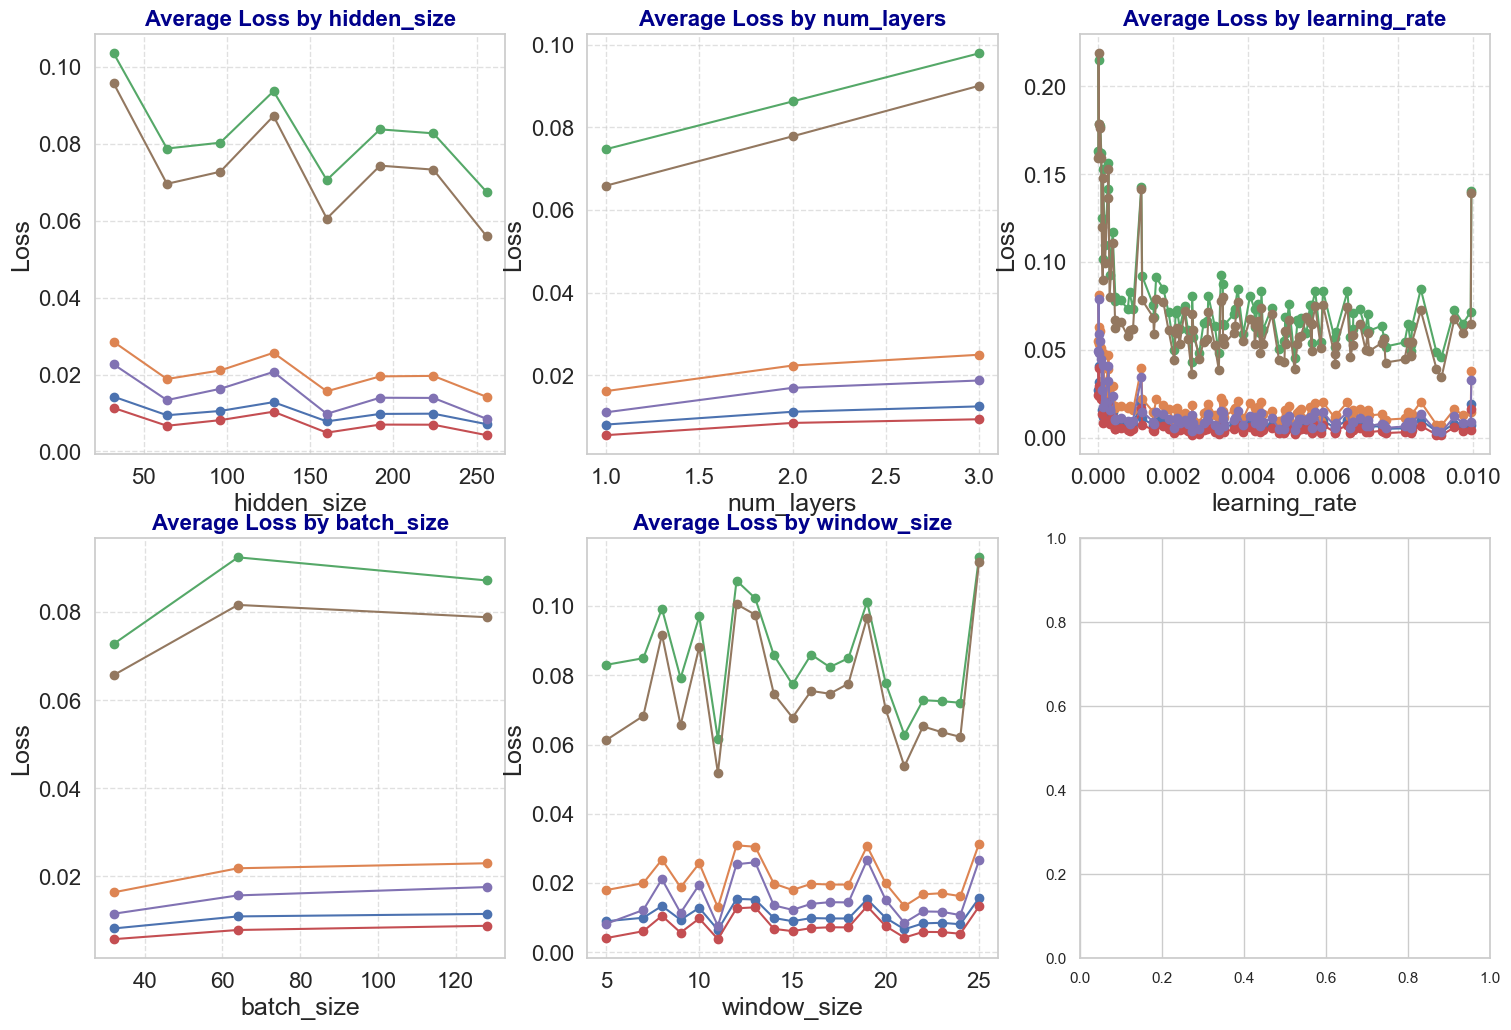

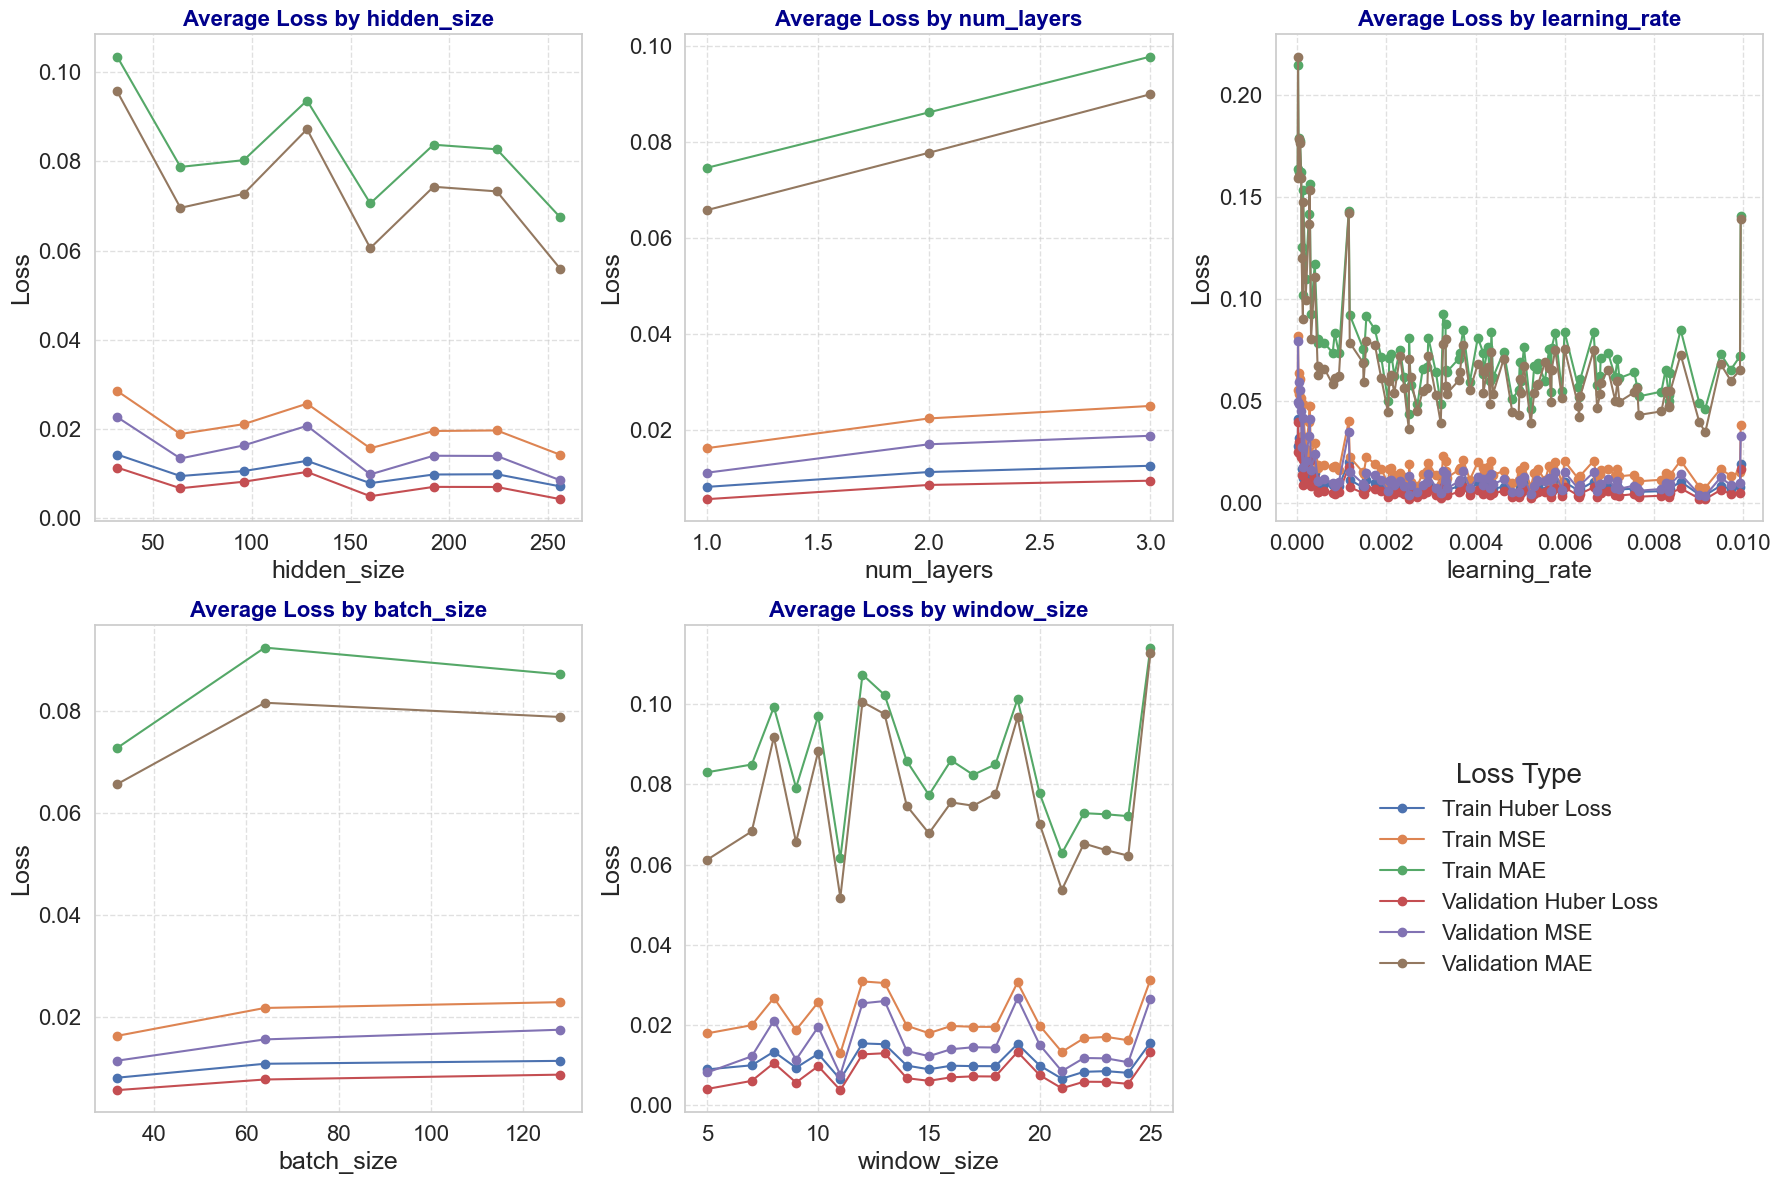

In [44]:
def plot_metrics_by_parameters(metrics_df, parameters, save_path):
    """
    Create a single figure with subplots for each parameter, showing average losses.

    Args:
        metrics_df (pd.DataFrame): DataFrame containing trial metrics and parameters.
        parameters (list): List of parameters to plot (e.g., ['hidden_size', 'num_layers', 'dropout']).
    """
    # Mapping loss types to more readable names
    loss_type_mapping = {
        "train_HuberLoss": "Train Huber Loss",
        "train_MSE": "Train MSE",
        "train_MAE": "Train MAE",
        "val_HuberLoss": "Validation Huber Loss",
        "val_MSE": "Validation MSE",
        "val_MAE": "Validation MAE"
    }

    num_params = len(parameters)
    ncols = 3  # Number of columns
    nrows = (num_params + ncols - 1) // ncols  # Dynamically calculate rows based on parameters
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 6 * nrows), sharex=False)

    # Flatten axes for easier iteration
    axes = axes.flatten()

    # Plot each parameter
    for i, (ax, parameter) in enumerate(zip(axes, parameters)):
        grouped = metrics_df.groupby(parameter).mean()  # Group by the parameter and calculate averages
        for loss, readable_name in loss_type_mapping.items():
            if loss in grouped.columns:
                ax.plot(grouped.index, grouped[loss], label=readable_name, marker='o', linestyle='-', linewidth=1.5)

        # Customize each subplot
        ax.set_xlabel(parameter, fontsize=18)
        ax.set_ylabel("Loss", fontsize=18)
        ax.tick_params(axis='both', which='major', labelsize=16)
        ax.set_title(f"Average Loss by {parameter}", fontsize=16, weight='bold', color='darkblue')
        ax.grid(True, linestyle='--', alpha=0.6)

    # Remove unused subplots if parameters < nrows * ncols
    for j in range(len(parameters), len(axes)):
        if j == len(parameters):  # Use the first unused subplot for the legend
            handles, labels = ax.get_legend_handles_labels()
            axes[j].legend(
                handles, labels, loc="center", fontsize=16, title="Loss Type", title_fontsize=20, frameon=False
            )
            axes[j].set_axis_off()  # Turn off the axis for the legend plot
        else:
            fig.delaxes(axes[j])  # Remove any additional unused subplots

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

# Example: Plot average losses for all parameters in one figure
parameters_to_plot = ["hidden_size", "num_layers", "learning_rate", "batch_size", "window_size"]#, "dropout"]
plot_metrics_by_parameters(all_metrics_df, parameters_to_plot, f"metrics_by_parameters_{model_name}.png")

### Predict the next 200 data points recursively

C:\Users\bar24\AppData\Local\Temp\ipykernel_19876\2125674564.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  init_window = torch.tensor(val_X[0], dtype=torch.float32).to(device)


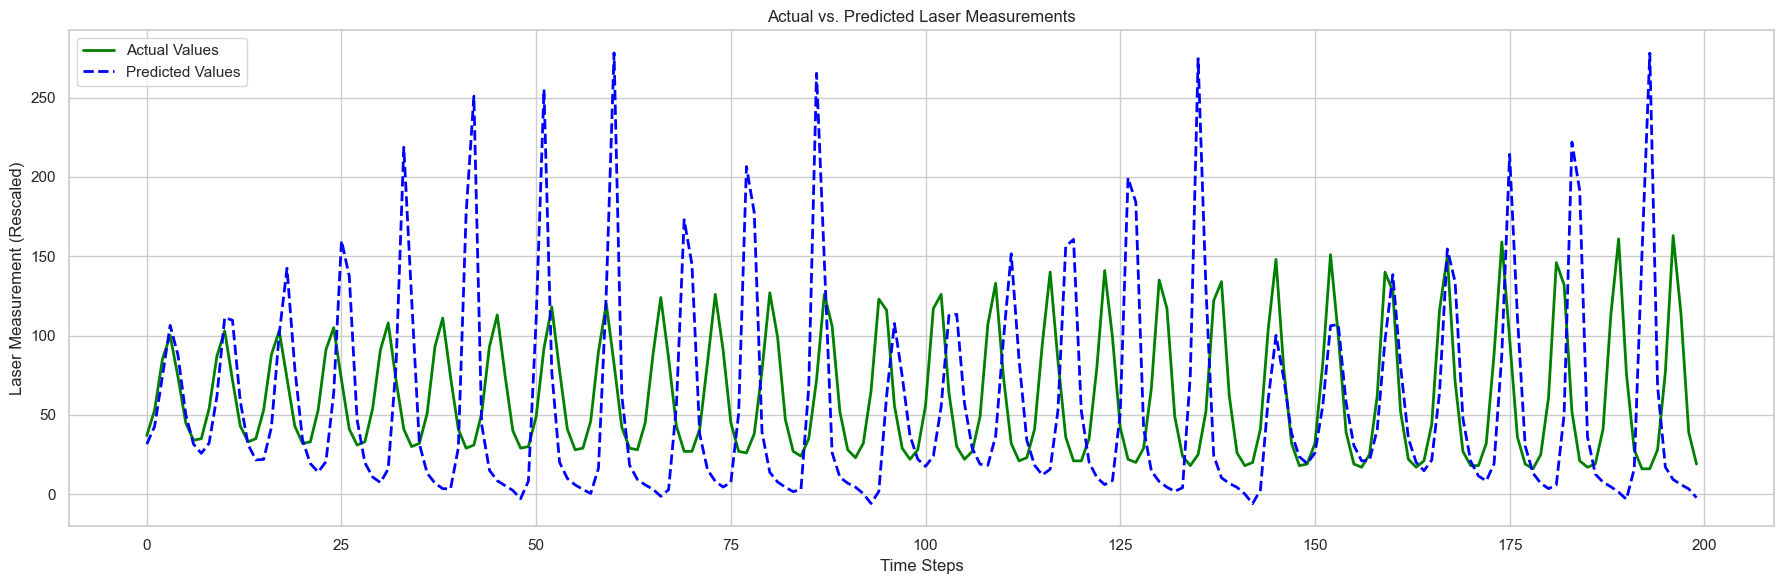

Metrics plot saved to actual_vs_predicted_plot_LSTM.png


In [45]:
def predict_and_inverse_transform(model, init_window, scaler, steps=200):
    """
    Perform recursive forecasting using the trained model and convert predictions back to the original range.

    Args:
        model: The trained LSTM model.
        init_window: The initial sequence window (tensor) in normalized form.
        scaler: The MinMaxScaler used for normalization.
        steps: Number of forecasting steps.

    Returns:
        np.array: Forecasted values in the original range.
    """
    model.eval()
    preds = []
    current_seq = init_window.clone().to(device)  # Ensure the initial window is on the correct device

    with torch.no_grad():
        for step in range(steps):
            # Forward pass
            input = current_seq.unsqueeze(0).contiguous()  # Add batch dimension
            pred = model(input)  # shape: (1, seq_len, forecast_steps)

            # Extract the first predicted value
            pred_value = pred.item()  # Extract the first step of the forecast
            preds.append(pred_value)

            # Update the sequence by appending the prediction and removing the oldest value
            next_value = torch.tensor([[pred_value]], dtype=torch.float32, device=device)
            current_seq = torch.cat((current_seq[1:], next_value), dim=0)

    # Convert predictions to numpy array
    preds = np.array(preds).reshape(-1, 1)

    # Inverse transform the predictions to the original range
    preds_original = scaler.inverse_transform(preds)

    return preds_original

def plot_signals(predictions_rescaled, actual_values, save_path):
    """
    Plot training and validation metrics after training and compare predictions with actual values.
    """
    plt.figure(figsize=(18, 6))

    # Plot Actual vs Predicted Values
    plt.plot(actual_values, label="Actual Values", color="green", linewidth=2)
    plt.plot(predictions_rescaled, label="Predicted Values", color="blue", linestyle="--", linewidth=2)
    plt.xlabel("Time Steps")
    plt.ylabel("Laser Measurement (Rescaled)")
    plt.title("Actual vs. Predicted Laser Measurements")
    plt.legend()

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()
    print(f"Metrics plot saved to {save_path}")
   
# Perform recursive forecasting to generate predictions
# Use the first sequence from the validation set as the initial window
init_window = torch.tensor(val_X[0], dtype=torch.float32).to(device)

# Predict and convert back to the original range
predicted_signal = predict_and_inverse_transform(best_model, init_window, scaler, steps=200)

# Compare with the actual values (also inverse transformed if needed)
actual_signal = scaler.inverse_transform(val_y[:len(predicted_signal)])

plot_signals(predicted_signal, actual_signal, f"actual_vs_predicted_plot_{model_name}.png")

In [ ]:
import torch.nn as nn

def evaluate_model_on_validation(best_model, val_loader):
    """
    Evaluate the best model on the validation dataset and calculate MSE and MAE using PyTorch loss functions.

    Args:
        best_model: The trained model.
        val_loader: The validation dataset (normalized).

    Returns:
        mse: Mean Squared Error.
        mae: Mean Absolute Error.
    """
    # Switch the model to evaluation mode
    best_model.eval()

    # Define PyTorch loss functions
    mse_criterion = nn.MSELoss()
    mae_criterion = nn.L1Loss()

    # Collect predictions and ground truth
    total_mse = 0.0
    total_mae = 0.0
    num_samples = 0

    with torch.no_grad():
        for batch in val_loader:
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)
            output = best_model(x_batch)

            # Calculate losses
            mse = mse_criterion(output, y_batch).item()
            mae = mae_criterion(output, y_batch).item()

            # Accumulate losses
            total_mse += mse * x_batch.size(0)
            total_mae += mae * x_batch.size(0)
            num_samples += x_batch.size(0)

    # Calculate average losses
    avg_mse = total_mse / num_samples
    avg_mae = total_mae / num_samples

    print(f"Validation MSE: {avg_mse}")
    print(f"Validation MAE: {avg_mae}")

    return avg_mse, avg_mae

# Evaluate the best model
mse, mae = evaluate_model_on_validation(best_model, val_loader)

### Load the trained model

In [ ]:
import json

def load_best_model():
    # Load the best hyperparameters
    with open(f"best_hyperparameters_{model_name}.json", "r") as f:
        best_params = json.load(f)

    # Recreate the model with the best hyperparameters
    best_model = LSTM(
        input_size=1,
        hidden_size=best_params["hidden_size"],
        num_stacked_layers=best_params["num_layers"]
    ).to(device)

    # Load the saved model weights
    best_model.load_state_dict(torch.load(model_pth_path))
    best_model.eval()

    return best_model, best_params

best_model, best_params = load_best_model()
print("Best hyperparameters are:", best_params)